### Using Python to Backtest Options Strategies

This is a backtesting engine for options. 

For the purpose of demonstration, this code only includes systematic strategies on a weekly, bimonthly, or monthly basis. Market timing on top of that could potentially improve the performance of the strategy, but it has been implemented

In order to run the code, we need to (1) have internet access to use YahooFinance and (2) download options data from OptionsDX and save locally. 

As of 6/23/2023, OptionsDX provides free end-of-day data for a limited number of tickers, such as SPY, SPX, VIX, and AAPL. 

Import modules

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import yfinance as yf

Define functions

In [2]:
def getDatesList(start, end):
    dates_list = [] 
    for i in range(1880,2150): # (including, not including)
        for j in range(1, 13): # (including, not including)
            if j <=9:
                dates_list.append((str(i)+str(0)+str(j)))
            else:
                dates_list.append((str(i)+str(j)))
    dates_list = dates_list[dates_list.index(str(start)):dates_list.index(str(end))+2]
    return dates_list

In [3]:
def addFrequencyBasedSignals(stock_data, condition, dates_list): # condition = 'monthly' , 'bimonthly' , 'weekly'
    stock_data['signal'] = 0 

    stock_data['Month'] = stock_data.index.month
    stock_data['Year'] = stock_data.index.year
    stock_data['Day'] = stock_data.index.day

    def last(df):
        return df.iloc[-1] # get the last element in a groupby
    def q25(df):
        return df.iloc[int(len(df)/4)] # get the last element in a groupby
    def q75(df):
        return df.iloc[int(len(df)/4*3)] # get the last element in a groupby
    def q50(df):
        return df.iloc[int(len(df)/4*2)] # get the last element in a groupby

    d2=stock_data.groupby(['Year','Month']).apply(q50)['Day'] # mid-months
    d4=stock_data.groupby(['Year','Month']).apply(last)['Day']
    d1=stock_data.groupby(['Year','Month']).apply(q25)['Day']
    d3=stock_data.groupby(['Year','Month']).apply(q75)['Day']

    ind = stock_data.groupby(['Year','Month']).apply(q75)['Day'].index
    
    if condition == 'monthly':
        for i in range(len(ind)):
            stock_data.loc[stock_data[(stock_data['Year']==ind[i][0])&
                                      (stock_data['Month']==ind[i][1])&
                                      (stock_data['Day']==int(d4.values[i]))].index, 'signal']=1
    
    elif condition == 'bimonthly':
        for i in range(len(ind)):
            stock_data.loc[stock_data[(stock_data['Year']==ind[i][0])&
                                      (stock_data['Month']==ind[i][1])&
                                      (stock_data['Day']==int(d2.values[i]))].index, 'signal']=1
            stock_data.loc[stock_data[(stock_data['Year']==ind[i][0])&
                                      (stock_data['Month']==ind[i][1])&
                                      (stock_data['Day']==int(d4.values[i]))].index, 'signal']=1
            
    elif condition == 'weekly':
        for i in range(len(ind)):
            stock_data.loc[stock_data[(stock_data['Year']==ind[i][0])&
                                      (stock_data['Month']==ind[i][1])&
                                      (stock_data['Day']==int(d1.values[i]))].index, 'signal']=1
            stock_data.loc[stock_data[(stock_data['Year']==ind[i][0])&
                                      (stock_data['Month']==ind[i][1])&
                                      (stock_data['Day']==int(d2.values[i]))].index, 'signal']=1              
            stock_data.loc[stock_data[(stock_data['Year']==ind[i][0])&
                                      (stock_data['Month']==ind[i][1])&
                                      (stock_data['Day']==int(d3.values[i]))].index, 'signal']=1
            stock_data.loc[stock_data[(stock_data['Year']==ind[i][0])&
                                      (stock_data['Month']==ind[i][1])&
                                      (stock_data['Day']==int(d4.values[i]))].index, 'signal']=1    
    
    
    # find all signals and calculate the holding period in between

    stock_data['count_days'] = range(0,len(stock_data))

    temp = pd.DataFrame(stock_data[stock_data['signal']==1].diff().shift(-1)['count_days'].values,
                 index=stock_data[stock_data['signal']==1].diff().shift(-1)['count_days'].index,
                 columns=['Holding Period'])

    # merge the holding period with the original dataframe

    frames = [stock_data, temp] 
    stock_data = pd.concat(frames, axis=1, join='outer') # outer for union and inner for intersection

    # get a copy with rows that have a positive signal

    signals = stock_data[stock_data['signal']==1].copy()
    signals['next_signal_date'] = signals.index
    signals['next_signal_date'] = signals['next_signal_date'].shift(-1)
    signals

    # limit the signals dataframe to the date range specified

    signals = signals[(signals.index >= datetime.datetime(int(dates_list[0][:-2]),
                                                               int(dates_list[0][-2:]),1))] 
    signals = signals[signals['next_signal_date'] < datetime.datetime(int(dates_list[-1][:-2]),
                                                                      int(dates_list[-1][-2:]),1)]
    signals = signals[signals['signal'] == 1]
    stock_data = stock_data[(stock_data.index >= datetime.datetime(int(dates_list[0][:-2]),
                                                                   int(dates_list[0][-2:]),1)) &
                            (stock_data.index < datetime.datetime(int(dates_list[-1][:-2]),
                                                                  int(dates_list[-1][-2:]),1))]

    return stock_data, signals

In [4]:
def clean_one_file(ticker, yyyymm): # enter 'spy' and '202001'
    df1 = (pl.scan_csv('optionsdx_data.nosync/'+ticker+"_eod_"+yyyymm+".txt")).collect()

    # rename the columns
    for i in range(1, len(df1.columns)):
        df1 = df1.rename({df1.columns[i]: df1.columns[i][1:]})

        
    # drop some of the columns
    df1 = df1.drop(['[QUOTE_UNIXTIME]', '[QUOTE_READTIME]', 
                    '[QUOTE_TIME_HOURS]', '[EXPIRE_UNIX]',
                    '[STRIKE_DISTANCE]', '[STRIKE_DISTANCE_PCT]',
                    '[C_SIZE]', '[P_SIZE]'])

    # get rid of the space charater
    df1 = pl.concat([df1.select([pl.col(pl.Utf8)]).select(pl.all().str.strip()), 
                     df1.select([pl.col(pl.Float64)])], how='horizontal')

    # convert strings to datetimes
    df1 = df1.with_columns(pl.col('[EXPIRE_DATE]').str.strptime(pl.Date, fmt='%Y-%m-%d').cast(pl.Datetime))
    df1 = df1.with_columns(pl.col('[QUOTE_DATE]').str.strptime(pl.Date, fmt='%Y-%m-%d').cast(pl.Datetime))

    # convert the rest of the strings to floats
    df1 = pl.concat([df1.select([pl.col(pl.Utf8)]).select(pl.all().cast(pl.Float64, strict=False)), 
                     df1.select([pl.exclude(pl.Utf8)])], how='horizontal')
    
    # replace nulls with zeros for call and put volumes
    df1 = df1.with_columns(pl.col("[C_VOLUME]").fill_null(strategy="zero"))
    df1 = df1.with_columns(pl.col("[P_VOLUME]").fill_null(strategy="zero"))
    
    # sort the columns
    df1 = df1.select(sorted(df1.columns))
    
    return df1
  

In [5]:
def get_options_data(ticker, dates_list):
    for i in range(len(dates_list[:-1])): 
        print(dates_list[i])
        if i == 0:
            df = clean_one_file(ticker, dates_list[i])
        else:
            df1 = clean_one_file(ticker, dates_list[i])
            df = pl.concat([df, df1])
    return df

In [6]:

def get_price_list(i, options, call_or_put, buy_or_sell, DTE_lower, DTE_upper, 
                   delta_lower, delta_upper, volume_threshold):

    # find all options that satisfy the requirement on the singal day

    selected_options = options.filter((pl.col("[QUOTE_DATE]") == signals[i,'Date'])&
                       (pl.col("[DTE]") >= DTE_lower)&
                       (pl.col("[DTE]") <= DTE_upper)&
                       (pl.col("["+call_or_put[0].upper()+"_DELTA]") >= delta_lower)&
                       (pl.col("["+call_or_put[0].upper()+"_DELTA]") <= delta_upper)&
                                      (pl.col(['['+call_or_put[0].upper()+'_VOLUME]'])>= volume_threshold))
    
    # exclude options with bid prices equal to zero
    if (call_or_put == 'call'):
        selected_options = selected_options.filter((pl.col("[C_BID]") != 0))
    elif (call_or_put == 'put'):
        selected_options = selected_options.filter((pl.col("[P_BID]") != 0))
        
    vmax = selected_options.select(pl.max('['+call_or_put[0].upper()+'_VOLUME]'))
    vmax = vmax[0,0]

    # added index zero in case we find more than one option, and if so we will just pick the first one

        
    selected_options = selected_options.filter((pl.col('['+call_or_put[0].upper()+'_VOLUME]') == vmax))[0]

    if len(selected_options) == 0:
        print('Cannot find enough options that satisfy the criteria.')
        return None, None
    else:
        # find the price list that matches the option
                
        exp_date = selected_options['[EXPIRE_DATE]'][0]
        strike = selected_options['[STRIKE]'][0]
        next_signal_date = signals[i,'next_signal_date']
        signal_date = signals[i,'Date']

        sequetial_data = options.filter((pl.col(['[STRIKE]']) == strike))
        sequetial_data = sequetial_data.filter((pl.col(['[EXPIRE_DATE]']) == exp_date))
        sequetial_data = sequetial_data.filter((pl.col(['[QUOTE_DATE]']) <= next_signal_date))
        sequetial_data = sequetial_data.filter((pl.col(['[QUOTE_DATE]']) >= signal_date))
        price_list, price_diff_list, volume_list = [], [], []
        if (call_or_put == 'call') and (buy_or_sell == 'buy'):
            volume_list = sequetial_data[:, '[C_VOLUME]']
            price_list = [sequetial_data[0, '[C_ASK]']]+sequetial_data['[C_BID]'].to_list()[1:]
            price_diff_list = [0]+(np.array(price_list[1:]) - np.array(price_list[:-1])).tolist()
        elif (call_or_put == 'call') and (buy_or_sell == 'sell'):
            volume_list = sequetial_data[:, '[C_VOLUME]']
            price_list = [sequetial_data[0, '[C_BID]']]+sequetial_data['[C_BID]'].to_list()[1:]
            price_diff_list = [0]+(-np.array(price_list[1:]) + np.array(price_list[:-1])).tolist()
        elif (call_or_put == 'put') and (buy_or_sell == 'buy'):
            volume_list = sequetial_data[:, '[P_VOLUME]']
            price_list = [sequetial_data[0, '[P_ASK]']]+sequetial_data['[P_BID]'].to_list()[1:]
            price_diff_list = [0]+(np.array(price_list[1:]) - np.array(price_list[:-1])).tolist()
        elif (call_or_put == 'put') and (buy_or_sell == 'sell'):   
            volume_list = sequetial_data[:, '[P_VOLUME]']
            price_list = [sequetial_data[0, '[P_BID]']]+sequetial_data['[P_ASK]'].to_list()[1:]
            price_diff_list = [0]+(-np.array(price_list[1:]) + np.array(price_list[:-1])).tolist()
        
        return price_list, price_diff_list, volume_list, sequetial_data['[QUOTE_DATE]'].to_list()

Input parameters

In [7]:
# choose frequency to be monthly, bimonthly, or weekly

frequency = 'weekly' 

# data available from 201501 to 202212

start = 201501 # including
end   = 202212 # including

volume_threshold = 0 # minimum daily volume threshold for each option contract
initial_equity = 100 # initial equity
bet_size_largest_leg = 0.01 # the percentage of equity to bet each time on the leg with the largest price

4-legged strategy

In [8]:
ticker                = ['spy',  'spy' ,'spy',  'spy' ] # ticker to read files
buy_or_sell           = ['sell',  'sell' ,'buy',  'buy' ]
call_or_put           = ['put',  'call','put',  'call'] 
DTE_lower             = [20,       5    ,20,       5    ] # including
DTE_upper             = [30,       10   ,30,       10   ] # including
delta_upper           = [-0.3,    0.4  ,-0.1,    0.2  ] # including
delta_lower           = [-0.4,    0.3  ,-0.2,    0.1  ] # including
num_shares_multiplier = [1,       2    ,1,       2    ] # cannot be zero

2-legged strategy

In [9]:
ticker                = ['spy',  'spy'  ] # ticker to read files
buy_or_sell           = ['sell',  'sell']
call_or_put           = ['call',  'put' ] 
DTE_lower             = [5,       5     ] # including
DTE_upper             = [10,       10   ] # including
delta_upper           = [0.2,    -0.0   ] # including
delta_lower           = [0.0,    -0.2   ] # including
num_shares_multiplier = [1,       1     ] # cannot be zero

In [10]:
# ticker                = ['spy',  'spy' ] # ticker to read files
# buy_or_sell           = ['sell',  'buy']
# call_or_put           = ['put',  'put' ] 
# DTE_lower             = [5,       30    ] # including
# DTE_upper             = [10,       60  ] # including
# delta_upper           = [-0.8,    -0.0     ] # including
# delta_lower           = [-1,    -0.2   ] # including
# num_shares_multiplier = [1,       1    ] # cannot be zero

1-legged strategy

In [11]:
# ticker                = ['spy' ] # ticker to read files
# buy_or_sell           = ['sell'] 
# call_or_put           = ['put' ] 
# DTE_lower             = [3     ] # including
# DTE_upper             = [5     ] # including
# delta_upper           = [-0.0  ] # including
# delta_lower           = [-0.1  ] # including
# num_shares_multiplier = [1     ] # cannot be zero

Data preperation

In [12]:
# get a list of relevant months to access the locally saved options data

dates_list = getDatesList(start, end)
dates_list[:5]

# download data from yahoo finance

tickers_list = ["SPY"] 

stock_data = yf.download(  # or "pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = tickers_list,

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        
        period = "max",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)""
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

index_list_nan =list(np.unique(np.where(stock_data.isnull())[0]))
stock_data.index[index_list_nan]
stock_data=stock_data.drop(stock_data.index[index_list_nan])
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29,25.047173,25.047173,24.922560,25.029371,1003200
1993-02-01,25.047168,25.207384,25.047168,25.207384,480500
1993-02-02,25.189596,25.278605,25.136190,25.260803,201300
1993-02-03,25.296391,25.545617,25.278589,25.527815,529400
1993-02-04,25.616828,25.688036,25.331999,25.634630,531500


Add trading signals

In [13]:
# enter 'weekly' 'monthly' or 'bimonthly' for frequency

stock_data, signals = addFrequencyBasedSignals(stock_data, frequency, dates_list) 
stock_data

# data cleaning

signals['Date'] = signals.index
signals.index = range(len(signals))

signals = pl.from_pandas(signals)

signals.head()

Open,High,Low,Close,Volume,signal,Month,Year,Day,count_days,Holding Period,next_signal_date,Date
f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,datetime[ns],datetime[ns]
176.966303,176.983455,174.488433,175.12291,158567300,1,1,2015,9,5527,5.0,2015-01-16 00:00:00,2015-01-09 00:00:00
170.424361,173.039418,170.235733,172.876511,211879600,1,1,2015,16,5532,5.0,2015-01-26 00:00:00,2015-01-16 00:00:00
175.517315,176.246093,174.779955,176.151779,92009700,1,1,2015,26,5537,4.0,2015-01-30 00:00:00,2015-01-26 00:00:00
171.967692,173.339516,170.733041,171.007401,197729700,1,1,2015,30,5541,5.0,2015-02-06 00:00:00,2015-01-30 00:00:00
177.103498,177.686533,175.697371,176.237534,125672000,1,2,2015,6,5546,5.0,2015-02-13 00:00:00,2015-02-06 00:00:00


In [14]:
# make a copy called reference

reference = stock_data.copy()

reference.head()

,Open,High,Low,Close,Volume,signal,Month,Year,Day,count_days,Holding Period
Date,,,,,,,,,,,
2015-01-02,176.949164,177.377861,175.062885,176.134628,121465900,0,1,2015,2,5522,NaN
2015-01-05,175.054304,175.225781,172.636458,172.953690,169632600,0,1,2015,5,5523,NaN
2015-01-06,173.270892,173.811055,170.501511,171.324615,209151400,0,1,2015,6,5524,NaN
2015-01-07,172.696468,173.811084,172.233481,173.459549,125346700,0,1,2015,7,5525,NaN
2015-01-08,174.917107,176.760513,174.899968,176.537582,147217800,0,1,2015,8,5526,NaN


In [15]:
# get the options data based on the tickers that are specified earlier

for i in range(len(np.unique(ticker))):
    globals()[ticker[i]+'_options'] = get_options_data(ticker[i], dates_list)
#     print(globals()[ticker[i]+'_options'].head())

201501
201502


/Users/twang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `fmt` is deprecated as an argument to `strptime`; use `format` instead.
/Users/twang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `fmt` is deprecated as an argument to `strptime`; use `format` instead.


201503
201504
201505
201506
201507
201508
201509
201510
201511
201512
201601
201602
201603
201604
201605
201606
201607
201608
201609
201610
201611
201612
201701
201702
201703
201704
201705
201706
201707
201708
201709
201710
201711
201712
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
201901
201902
201903
201904
201905
201906
201907
201908
201909
201910
201911
201912
202001
202002
202003
202004
202005
202006
202007
202008
202009
202010
202011
202012
202101
202102
202103
202104
202105
202106
202107
202108
202109
202110
202111
202112
202201
202202
202203
202204
202205
202206
202207
202208
202209
202210
202211
202212


Run a backtest

In [16]:
df = pd.DataFrame()

beg_equity = initial_equity

# if no signal
if len(signals)==0:
    print('There is no trading signal.')

# if there is at least one signal
else:
    
    # for every signal
    for i in range(len(signals)):
        print(i)
        price_list, date_list, diff_list, price_lists, diff_lists, len_lists, equity = [], [], [], [], [], [], []
        volume_list, volume_lists = [], []
        for j in range(len(ticker)):
            
            # get a list of prices and a list of dates
            try:
                price_list, diff_list, volume_list, date_list = get_price_list(i, globals()[ticker[j]+'_options'], 
                                 call_or_put[j], buy_or_sell[j], DTE_lower[j], DTE_upper[j], 
                                 delta_lower[j], delta_upper[j], volume_threshold)
            # error
            except:
                break
            else:
                diff_lists.append(diff_list)
                price_lists.append(price_list)
                volume_lists.append(volume_list)
                len_lists.append(len(price_list))
        
        # after getting all legs, only do something if the length matches
        if len(price_lists) == len(ticker):
            
            # once one leg expires, close out the position
            price_lists = [price_lists[i][:min(len_lists)] for i in range(len(price_lists))]
            price_lists = np.array(price_lists)
#             print(price_lists)
            diff_lists = [diff_lists[i][:min(len_lists)] for i in range(len(diff_lists))]
            diff_lists = np.array(diff_lists)
#             print(diff_lists)
            date_list = date_list[:min(len_lists)]
    
            volume_lists = [volume_lists[i][:min(len_lists)] for i in range(len(volume_lists))]
            volume_lists = np.array(volume_lists)
            
            # the date of opening the position
            print(date_list[0])
            # the list of prices of options traded
#             print(price_lists) 
#             print(volume_lists.reshape(len(ticker),-1))
            
            num_shares = beg_equity*bet_size_largest_leg/max(price_lists[:,0])
#             print(num_shares)
            ind = list(price_lists.T[0]).index(max(price_lists[:,0]))
            num_shares_list = (np.array(num_shares_multiplier)/num_shares_multiplier[ind]*num_shares).reshape(-1,1)
#             print(num_shares_list)
#             print(diff_lists*num_shares_list)
            equity = np.cumsum([beg_equity]+sum(diff_lists*num_shares_list)[1:].tolist())
#             print(equity)
            beg_equity = equity[-1]  
#             print(beg_equity)
            df = pd.concat([df, pd.DataFrame(equity, index=date_list, columns=['Equity'])])
#             print(df)

# remove duplicate indices
df = df[~df.index.duplicated(keep='first')]


0
2015-01-09 00:00:00
1
2015-01-16 00:00:00
2
Cannot find enough options that satisfy the criteria.
3
2015-01-30 00:00:00
4
2015-02-06 00:00:00
5
2015-02-13 00:00:00
6
Cannot find enough options that satisfy the criteria.
7
2015-02-27 00:00:00
8
Cannot find enough options that satisfy the criteria.
9
2015-03-17 00:00:00
10
2015-03-24 00:00:00
11
2015-03-31 00:00:00
12
2015-04-09 00:00:00
13
2015-04-16 00:00:00
14
2015-04-23 00:00:00
15
2015-04-30 00:00:00
16
2015-05-08 00:00:00
17
2015-05-15 00:00:00
18
2015-05-22 00:00:00
19
2015-05-29 00:00:00
20
Cannot find enough options that satisfy the criteria.
21
2015-06-16 00:00:00
22
2015-06-23 00:00:00
23
2015-06-30 00:00:00
24
2015-07-09 00:00:00
25
2015-07-17 00:00:00
26
2015-07-24 00:00:00
27
2015-07-31 00:00:00
28
Cannot find enough options that satisfy the criteria.
29
Cannot find enough options that satisfy the criteria.
30
Cannot find enough options that satisfy the criteria.
31
Cannot find enough options that satisfy the criteria.
32

2021-07-30 00:00:00
316
2021-08-09 00:00:00
317
2021-08-17 00:00:00
318
2021-08-24 00:00:00
319
2021-08-31 00:00:00
320
2021-09-09 00:00:00
321
2021-09-16 00:00:00
322
2021-09-23 00:00:00
323
2021-09-30 00:00:00
324
2021-10-08 00:00:00
325
2021-10-15 00:00:00
326
2021-10-22 00:00:00
327
2021-10-29 00:00:00
328
2021-11-08 00:00:00
329
2021-11-15 00:00:00
330
2021-11-22 00:00:00
331
2021-11-30 00:00:00
332
2021-12-08 00:00:00
333
2021-12-16 00:00:00
334
2021-12-23 00:00:00
335
2021-12-31 00:00:00
336
2022-01-10 00:00:00
337
2022-01-18 00:00:00
338
2022-01-25 00:00:00
339
2022-01-31 00:00:00
340
2022-02-07 00:00:00
341
2022-02-14 00:00:00
342
2022-02-22 00:00:00
343
2022-02-28 00:00:00
344
2022-03-08 00:00:00
345
2022-03-16 00:00:00
346
2022-03-24 00:00:00
347
2022-03-31 00:00:00
348
2022-04-08 00:00:00
349
2022-04-18 00:00:00
350
2022-04-25 00:00:00
351
2022-04-29 00:00:00
352
2022-05-09 00:00:00
353
2022-05-16 00:00:00
354
2022-05-23 00:00:00
355
2022-05-31 00:00:00
356
2022-06-08 00:00

Result

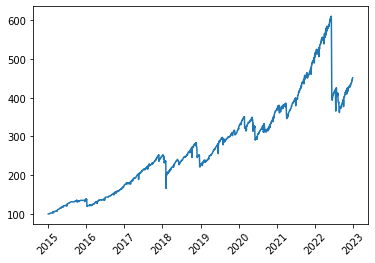

Sharpe Ratio (Rf = 0.02): 0.8284
Annualized Return: 0.2165
Max Drawdown: -0.4076


In [17]:
# define the risk free rate
Rf = 0.02

# combine the dataframes
res = pd.concat([df, reference] , axis=1, join='outer') 

# fill the values that are nan
res.iloc[0, res.columns.get_loc('Equity')] = initial_equity
res['Equity'] = res['Equity'].fillna(method='ffill')

# plot the equity curve
plt.plot(res['Equity'])
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()

# print the summary
mean_ret = np.mean(res['Equity']/res['Equity'].shift(1)-1)
stdev = np.std(res['Equity']/res['Equity'].shift(1)-1)
print('Sharpe Ratio (Rf = '+str(Rf)+'): ',
      "{:.4f}".format((mean_ret-Rf/250)/stdev*np.sqrt(250)),sep='')
print('Annualized Return: ',"{:.4f}".format(mean_ret*250),sep='')

Roll_Max = pd.DataFrame(res['Equity']).cummax()
Daily_Drawdown = pd.DataFrame(res['Equity'])/Roll_Max - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()

print('Max Drawdown: ',"{:.4f}".format(Max_Daily_Drawdown.values.min()),sep='')